In [1]:
import numpy as np
import healpy as hp
import pandas as pd
import seaborn as sns

import astropy.table
import astropy.coordinates as ac
from astropy import units as u

import completeness_utils

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# For esthetics, this is optional
sns.set_context("talk")

Load catalogue data
=========

In [4]:
print("Reading Gaia...")
gaia = pd.read_csv("../data/DR3_SOS.full.csv.gz")

print("Reading ASAS+PS1...") #see map_computing_examples for the procedure to produce this catalogue (see documentation in Mateu et al. 2020)
asasps1 = pd.read_csv("../data/asas_snii_j19_ps1_bonafide_s17.csv.gz")

Reading Gaia...
Reading ASAS+PS1...


In [10]:
sc_asasps1  =  ac.SkyCoord(ra=np.array(asasps1["ra"])*u.deg, dec=np.array(asasps1["dec"])*u.deg,  distance=np.array(asasps1["distance"])*u.kpc, frame='icrs')
sc_gaia =  ac.SkyCoord(ra=np.array(gaia["ra"])*u.deg,      dec=np.array(gaia["dec"])*u.deg, distance=np.array(gaia["Dist_M18_sfdAG"])*u.kpc, frame='icrs')

sc_asasps1.RRType = asasps1["RRType"]
sc_gaia.RRType = gaia["Type"]

sc_asasps1.G = asasps1["Gmag"]
sc_gaia.G = gaia["phot_g_mean_mag"]
sc_gaia.ruwe = gaia["ruwe"]
sc_gaia.bep = gaia["phot_bp_rp_excess_factor_norm"]

Compute Map vs Distance along a line of sight
--------

All
ruwe<1.4
BEP<3


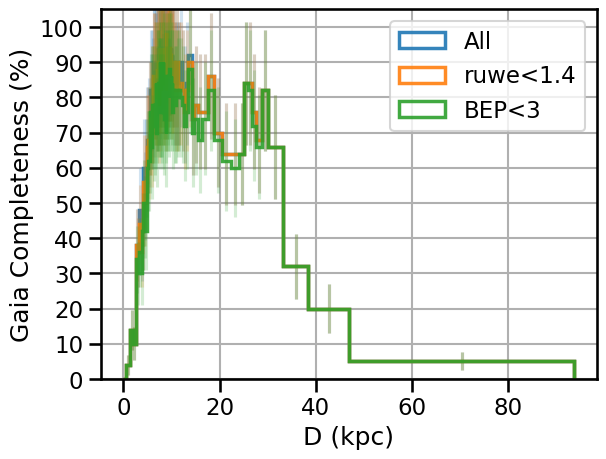

In [24]:
los_coo = ac.SkyCoord(10.*u.deg, 0*u.deg, frame='galactic')
rrt="RRc"

m_no_filter = sc_gaia.G<24.
m_ruwe = sc_gaia.ruwe<1.4
m_bep = sc_gaia.bep<3
m_all = [m_no_filter, m_ruwe, m_bep, m_ruwe & m_bep]
m_lab = ["All","ruwe<1.4", "BEP<3", "ruwe<1.4 & BEP<3"]

for ii in range(len(m_all))[:3]:
    print(m_lab[ii])
    rs, C, eC, Ntot_r, Ncommon_r, Cmean = completeness_utils.completeness_los(los_coo, sc_asasps1[sc_asasps1.RRType==rrt], 
                                                           sc_gaia[ (sc_gaia.RRType==rrt) & m_all[ii]], 
                                                           los_size=20*u.deg, sky_tol=3*u.arcsec,
                                                           Nmin=50, verbose=False)
    
    #----Plot---------------------------------------------
    ro = (rs[:-1] + rs[1:])/2.   
    ax=plt.subplot(111)
    ax.hist(ro,weights=C*100,bins=rs,histtype='step',lw=2.5,color=f'C{ii}',alpha=0.9,label=m_lab[ii])
    ax.errorbar(ro,C*100,yerr=eC*100,marker=None,alpha=0.2,color=f'C{ii}',ls='none')

ax.legend()
ax.set_ylim(0,105)
ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax.set_xlabel("D (kpc)")
ax.set_ylabel("Gaia Completeness (%)")
ax.grid()

Compute Gaia DR3 SOS's 3D maps for RRab and RRc
================

In [58]:
#--------------Gaia's 3D selection function (from x-match against ASAS+PS1)-------------------
nside=2**2
npix = hp.nside2npix(nside)
hpi = np.arange(npix,dtype=int) #healpix indices for current map 
nest=False
los, bos = hp.pix2ang(nside, hpi, lonlat=True, nest=nest)


m_full = (sc_gaia.G<24) 
m_ruwe = sc_gaia.ruwe<1.4
m_bep = sc_gaia.bep<3

m_all = [m_no_filter, m_ruwe, m_bep, m_ruwe & m_bep]
m_lab = ["all","ruwe_lt_1.4", "BEP_lt3", "ruwe_lt_1.4_BEP_lt_3"]


#All surveys
rrt = 'RRab'
rrt = 'RRc'
for ii in range(len(m_all)):

    print(f"--- Computing maps with {m_lab[ii]} mask ----")
    mm = m_all[ii]
    
    cat1_coo = sc_asasps1[sc_asasps1.RRType==rrt] #Cat1 is the reference catalogue
    cat2_coo = sc_gaia[(sc_gaia.RRType==rrt) & mm] #Cat2 is the problem catalogue
    outlabel = dict(gaia = "gaiadr3.sos", ps1="ps1_wgdr3ref", asas="asas_wgdr3ref")
    skytols  = dict(gaia = 1.*u.arcsec, ps1=1.*u.arcsec, asas=5.*u.arcsec)
    fill     = dict(gaia=True, ps1=False, asas=False)
        
    survey = 'gaia'
    
    print(f"Computing completeness for {rrt} in {survey} ...")  

    hpis, ls, bs, ris, rfs = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    Cs, eCs = np.array([]), np.array([])
    j=0

    for lo, bo in zip(los,bos) :

        #Completeness vs r for lo,bo
        if j % 20 == 0 :   print(f" Computing C(r) for lo={lo:6.2f}, bo={bo:+5.2f} ({j}/{los.size})")      
        los_coo = ac.SkyCoord(lo*u.deg, bo*u.deg, frame='galactic')
        ro, C, eC, Ntot_r, Ncommon_r, Cmean = completeness_utils.completeness_los(los_coo, cat1_coo, cat2_coo, fill_with_ecliptic_opposite=fill[survey],
                                                           los_size=(8.2*2)*u.deg, sky_tol=skytols[survey],
                                                           Nmin=50, verbose=False)

        hpis= np.append(hpis, hpi[j]*np.ones_like(C))
        ls = np.append(ls, lo*np.ones_like(C))
        bs = np.append(bs, bo*np.ones_like(C))
        ris= np.append(ris, ro[:-1])
        rfs= np.append(rfs, ro[1:])
        Cs = np.append(Cs, C)
        eCs= np.append(eCs, eC)
        j+=1
    
    
        #Store in DataFrame     
        printout = pd.DataFrame(data=dict(hpix=hpis,l=ls,b=bs,D_o=ris,D_f=rfs,C=Cs,eC=eCs))
        #Print tex table for paper
        outname=f"{outlabel[survey]}.filt_{m_lab[ii]}.{rrt.lower()}"
    #     astropy.io.ascii.write(astropy.table.Table.from_pandas(printout), 
    #                             output=f"maps/completeness3d.{outname}.tex", overwrite=True,
    #                             Writer=astropy.io.ascii.Latex,
    #                             formats={'hpix':'%4d','l':'%6.2f','b':'%+5.2f',"D_o":"%5.1f","D_f":"%5.1f","C":"%4.2f","eC":"%4.2f"})
    
        # printout_t = astropy.table.Table.from_pandas(printout)
        # astropy.io.ascii.write(printout_t,output=f"RRL_SF_data/completeness3d.{outname}.dat", 
        #                  overwrite=True,format='fixed_width', delimiter=' ',
        #                  formats={'hpix':'%4d','l':'%6.2f','b':'%+5.2f',"D_o":"%5.1f","D_f":"%5.1f","C":"%4.2f","eC":"%4.2f"})

    #Print csv table for convenience
    printout.to_csv(f"../maps/completeness3d.{outname}.csv",index=False,)

print("Done")

--- Computing maps with all mask ----
Computing completeness for RRc in gaia ...
 Computing C(r) for lo= 45.00, bo=+78.28 (0/192)
 Computing C(r) for lo=255.00, bo=+54.34 (20/192)
 Computing C(r) for lo=  0.00, bo=+30.00 (40/192)
 Computing C(r) for lo=101.25, bo=+19.47 (60/192)
 Computing C(r) for lo=180.00, bo=+9.59 (80/192)
 Computing C(r) for lo=281.25, bo=+0.00 (100/192)
 Computing C(r) for lo= 11.25, bo=-19.47 (120/192)
 Computing C(r) for lo= 90.00, bo=-30.00 (140/192)
 Computing C(r) for lo=191.25, bo=-41.81 (160/192)
 Computing C(r) for lo= 22.50, bo=-66.44 (180/192)
--- Computing maps with ruwe_lt_1.4 mask ----
Computing completeness for RRc in gaia ...
 Computing C(r) for lo= 45.00, bo=+78.28 (0/192)
 Computing C(r) for lo=255.00, bo=+54.34 (20/192)
 Computing C(r) for lo=  0.00, bo=+30.00 (40/192)
 Computing C(r) for lo=101.25, bo=+19.47 (60/192)
 Computing C(r) for lo=180.00, bo=+9.59 (80/192)
 Computing C(r) for lo=281.25, bo=+0.00 (100/192)
 Computing C(r) for lo= 11.25,

Make summary plots for Completeness vs Distance at: fixed l varying b and fixed b, varying l
-------------

In [59]:
gaia3Dab = pd.read_csv("../maps/completeness3d.gaiadr3.sos.filt_All.rrab.csv",dtype=dict(hpix=int))
gaia3Dc  = pd.read_csv("../maps/completeness3d.gaiadr3.sos.filt_All.rrc.csv",dtype=dict(hpix=int))

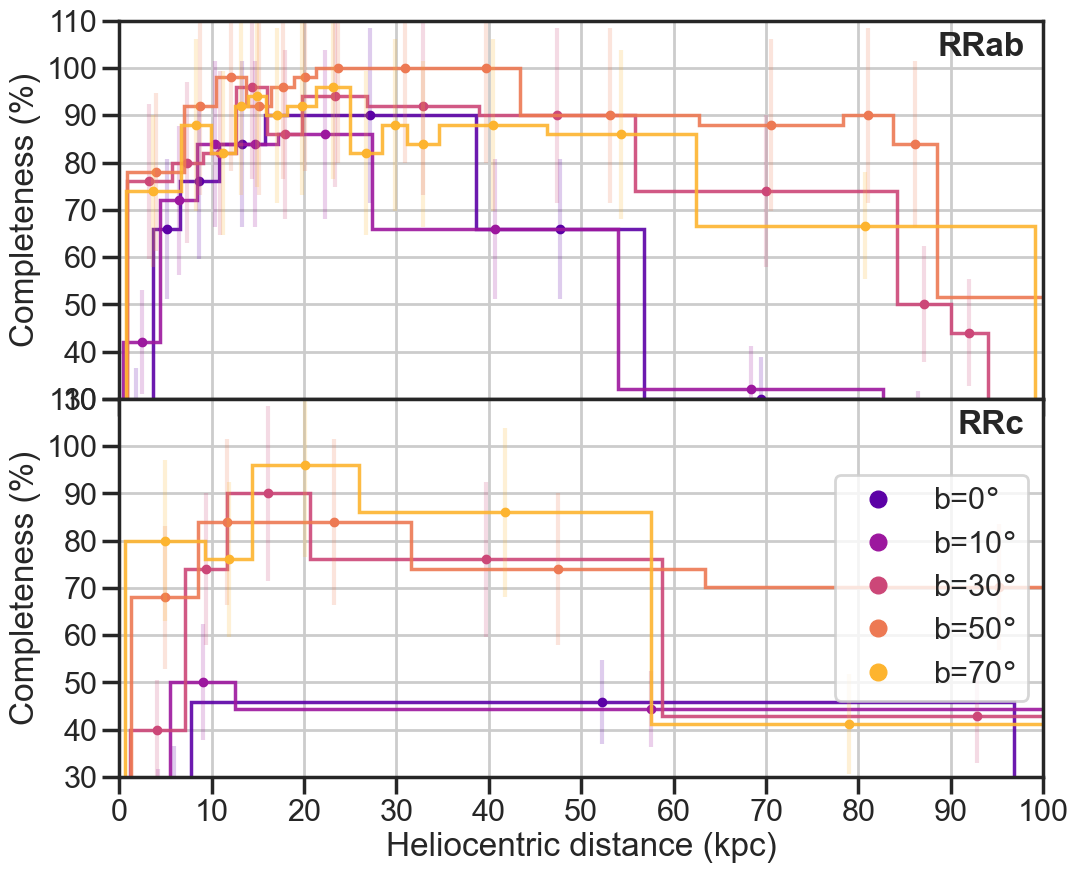

In [64]:
sns.set_style('ticks')
sns.set_context('poster')


fig=plt.figure(1,figsize=(11,9), )
fig.subplots_adjust(left=0.12,right=0.96,top=0.98,bottom=0.14,hspace=0.)
ax=fig.add_subplot(211,)   
ax1=fig.add_subplot(212)   

ls=[5,45,90,145,180]
bs=[0,10,30,50,70]
cols=sns.color_palette("plasma", len(ls))

completeness_map = gaia3Dab

for jj in range(len(ls)) : #np.arange(0,360.,90.):
 
 bo=5.
 lo=ls[jj]
 label = f"l={lo}$\degree$" 
    
 lo=180.
 bo=bs[jj]
 label=f"b={bo}$\degree$"   

 #RRAB    
 coo = ac.SkyCoord(l = lo*u.deg, b = bo*u.deg, frame = 'galactic')
 losC = completeness_utils.query_3d_map(gaia3Dab ,coo)   
    
 rmid = (losC.D_f+losC.D_o)/2.
 rs = np.append(np.min(losC["D_o"]),losC["D_f"])

 ax.plot(rmid,losC.C*100,'.',color=cols[jj],label=f"l={lo}$\degree$")
 #The histogram plot gives a better representation of the data. Completeness was estimated in (non-uniform) distance bins to ensure a given Poisson noise.
 ax.hist(rmid,weights=losC.C*100,bins=rs,histtype='step',lw=2.5,color=cols[jj],alpha=0.9)
 ax.errorbar(rmid,losC.C*100,yerr=losC.eC*100,marker=None,alpha=0.2,color=cols[jj],ls='none')
 
 #RRC   
 losC = completeness_utils.query_3d_map(gaia3Dc ,coo)   
    
 rmid = (losC.D_f+losC.D_o)/2.
 rs = np.append(np.min(losC["D_o"]),losC["D_f"])

 ax1.plot(rmid,losC.C*100,'.',color=cols[jj],label=label)
 #The histogram plot gives a better representation of the data. Completeness was estimated in (non-uniform) distance bins to ensure a given Poisson noise.
 ax1.hist(rmid,weights=losC.C*100,bins=rs,histtype='step',lw=2.5,color=cols[jj],alpha=0.9)
 ax1.errorbar(rmid,losC.C*100,yerr=losC.eC*100,marker=None,alpha=0.2,color=cols[jj],ls='none')

    
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax1.xaxis.set_major_locator(plt.MultipleLocator(10))

ax.yaxis.set_major_locator(plt.MultipleLocator(10))
ax1.yaxis.set_major_locator(plt.MultipleLocator(10))

ax.grid(which='major')
ax1.grid(which='major')

#ax.legend(markerscale=2, ncol=2, loc='lower left')

ax.set_xlim(0,100)
ax1.set_xlim(0,100)
ax.xaxis.set_ticklabels([])
ax1.set_xlabel('Heliocentric distance (kpc)')

ax.set_ylabel('Completeness (%)')
ax1.set_ylabel('Completeness (%)')

ax.text(0.98,0.97,'RRab',fontweight='bold',ha='right',va='top', transform=ax.transAxes)
ax1.text(0.98,0.97,'RRc',fontweight='bold',ha='right',va='top', transform=ax1.transAxes)


ax.set_ylim(30,110)
ax1.set_ylim(30,110)

#ax1.legend()
ax1.legend(markerscale=2, loc='center right')#, loc='lower left')